In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
#import qtl.io

import scipy

from scipy import stats
import itertools

import re
import scanpy as sc
import infercnvpy as cnv
from anndata import AnnData
import subprocess
import gseapy
import palettable

from matplotlib.colors import Colormap, TwoSlopeNorm
from typing import Dict, Union, Tuple, Optional

from scipy.sparse import issparse

In [2]:
sc.settings.set_figure_params(figsize=(10, 10))
sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.10.4 louvain==0.8.0 pynndescent==0.5.8


In [2]:
adata = sc.read_h5ad('p2389_cleaned_w_snv_clusters_final.h5ad')
adata

AnnData object with n_obs × n_vars = 23931 × 24594
    obs: 'Sample_ID', 'Patient', 'Pool', 'MGH1002', 'MGH1078', 'MGH1113', 'MGH1326', 'MGH1598', 'MGH2389', 'MGH2819', 'MGH2974', 'DROPLET.TYPE', 'SNG.BEST.GUESS', 'Z.MARGIN', 'Z.DBL', 'Sample_MGH_ID', 'Patient_MGH_ID', 'n_genes', 'percent_mito', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scrublet_score', 'doublet', 'Pool_ID', 'Description', 'Samples_in_pool', 'Sample_alternative_ID', 'Site', 'batch', 'T00655-15', 'T01027-4', 'T01327-8', 'T01354-3', 'T01687-3', 'T01488-12', 'refCL1', 'altCL1', 'refCL17', 'altCL17', 'refCL4', 'altCL4', 'refCL14', 'altCL14', 'refCL9', 'altCL9', 'refCL3', 'altCL3', 'refCL7', 'altCL7', 'refCL12', 'altCL12', 'refCL8', 'altCL8', 'refCL5', 'altCL5', 'refCL15', 'altCL15', 'refCL13', 'altCL13', 'refCL16', 'altCL16', 'refCL6', 'altCL6', 

In [3]:
def get_hex_string(c):
    return '#{:02X}{:02X}{:02X}'.format(*c)

def get_phylogic_color_scale():
    """Generate dictionary defining phylogic cluster colors."""
    phylogic_color_list = [[166, 17, 129],
                           [39, 140, 24],
                           [103, 200, 243],
                           [248, 139, 16],
                           [16, 49, 41],
                           [93, 119, 254],
                           [152, 22, 26],
                           [104, 236, 172],
                           [249, 142, 135],
                           [55, 18, 48],
                           [83, 82, 22],
                           [247, 36, 36],
                           [0, 79, 114],
                           [243, 65, 132],
                           [60, 185, 179],
                           [185, 177, 243],
                           [139, 34, 67],
                           [178, 41, 186],
                           [58, 146, 231],
                           [130, 159, 21],
                           [161, 91, 243],
                           [131, 61, 17],
                           [248, 75, 81],
                           [32, 75, 32],
                           [45, 109, 116],
                           [255, 169, 199],
                           [55, 179, 113],
                           [34, 42, 3],
                           [56, 121, 166],
                           [172, 60, 15],
                           [115, 76, 204],
                           [21, 61, 73],
                           [67, 21, 74],  # Additional colors, uglier and bad
                           [123, 88, 112],
                           [87, 106, 46],
                           [37, 66, 58],
                           [132, 79, 62],
                           [71, 58, 32],
                           [59, 104, 114],
                           [46, 107, 90],
                           [84, 68, 73],
                           [90, 97, 124],
                           [121, 66, 76],
                           [104, 93, 48],
                           [49, 67, 82],
                           [71, 95, 65],
                           [127, 85, 44],  # even more additional colors, gray
                           [88, 79, 92],
                           [220, 212, 194],
                           [35, 34, 36],
                           [200, 220, 224],
                           [73, 81, 69],
                           [224, 199, 206],
                           [120, 127, 113],
                           [142, 148, 166],
                           [153, 167, 156],
                           [162, 139, 145],
                           [0, 0, 0]]  # black
    colors_dict = {str(i): get_hex_string(c) for i, c in enumerate(phylogic_color_list)}
    return colors_dict


phylo_colors=get_phylogic_color_scale()

In [4]:
clust_list = ['cluster_1', 'cluster_2', 'cluster_3',
                          'cluster_4', 'cluster_5', 'cluster_6',
                          'cluster_7', 'cluster_8', 'cluster_9',
                          'cluster_10', 'cluster_11', 'cluster_12',
                          'cluster_13', 'cluster_14', 'cluster_15','cluster_16','cluster_17','cluster_18',np.nan]

phylo_clust_colors = [phylo_colors[str(i)] for i in range(1,len(clust_list))]
phylo_clust_colors.append('gray')
clusts_colors = dict(zip(clust_list, phylo_clust_colors))
clusts_colors[None] = 'gray'

In [5]:
phylo_colors_for_umap = [phylo_clust_colors[0],phylo_clust_colors[1],phylo_clust_colors[2],phylo_clust_colors[3],
                               phylo_clust_colors[4],phylo_clust_colors[7],phylo_clust_colors[9],
                               phylo_clust_colors[10],phylo_clust_colors[11],
                         phylo_clust_colors[12],phylo_clust_colors[14],
                         'gray']

## adata from liza

In [7]:
adata_from_liza = sc.read_h5ad('p2389_withCNV_annotations_and_TN.h5ad')
tumor_cells = adata_from_liza[adata_from_liza.obs["cnv_status"] == "tumor", :]
cnv_calls_matrix = tumor_cells.obsm['X_cnv'].todense()

In [9]:
ignat_assign = adata_from_ignat.obs['cell_snv_cluster']

In [10]:
longer_barcodes = adata_from_liza.obs.index.to_list()
shorter_barcodes = ['-'.join(i.split('-')[0:2]) for i in longer_barcodes]
len(shorter_barcodes)

21837

In [11]:
adata_from_liza.obs['shorter_barcodes'] = shorter_barcodes
adata_from_liza.obs

Sample_ID                 Patient     Pool  \
AAACCCAAGACCATTC-1-0-0-0-0  Pool_3_N6  1326-8; 2389-3; 2974-3  A, C, D   
AAACCCAAGATGCTAA-1-0-0-0-0  Pool_3_N6  1326-8; 2389-3; 2974-3  A, C, D   
AAACCCAAGCTCATAC-1-0-0-0-0  Pool_3_N6  1326-8; 2389-3; 2974-3  A, C, D   
AAACCCACAAAGCTAA-1-0-0-0-0  Pool_3_N6  1326-8; 2389-3; 2974-3  A, C, D   
AAACCCACAGAACTTC-1-0-0-0-0  Pool_3_N6  1326-8; 2389-3; 2974-3  A, C, D   
...                               ...                     ...      ...   
TTTGATCCAGAAACCG-1-1        Pool7_N10  1326-3; 1598-7; 2389-4  A, B, C   
TTTGTTGAGTCCGTCG-1-1        Pool7_N10  1326-3; 1598-7; 2389-4  A, B, C   
TTTGTTGGTCACCGCA-1-1        Pool7_N10  1326-3; 1598-7; 2389-4  A, B, C   
TTTGTTGGTGGCTTAT-1-1        Pool7_N10  1326-3; 1598-7; 2389-4  A, B, C   
TTTGTTGTCAGCACCG-1-1        Pool7_N10  1326-3; 1598-7; 2389-4  A, B, C   

                            T00655-15   T01027-4   T01327-8   T01354-3  \
AAACCCAAGACCATTC-1-0-0-0-0 -1199.8397 -1136.5727 -1155.3018  -580.7483   
AAACCCAAGATGCTAA-1-0-0-0-0  -658.4495  -569.9685  -596.6641  -372.8386   
AAACCCAAGCTCATAC-1-0-0-0-0  -318.8363  -317.3492  -332.8599  -163.3229   
AAACCCACAAAGCTAA-1-0-0-0-0  -815.5581  -746.1711  -778.7649  -522.6375   
AAACCCACAGAACTTC-1-0-0-0-0  -775.6894  -714.9819  -760.4059  -532.8264   
...                               ...        ...        ...        ...   
TTTGATCCAGAAACCG-1-1        -251.5701  -258.0400  -251.6673  -223.2448   
TTTGTTGAGTCCGTCG-1-1        -429.1330  -435.5102  -453.9696  -329.5831   
TTTGTTGGTCACCGCA-1-1        -378.0907  -342.4667  -382.2145  -266.5103   
TTTGTTGGTGGCTTAT-1-1       -1580.7836 -1666.4250 -1438.1002 -1054.1963   
TTTGTTGTCAGCACCG-1-1       -1399.7757 -1396.4392 -1372.0626  -904.4749   

                             T01687-3 DROPLET.TYPE SNG.BEST.GUESS  ...  \
AAACCCAAGACCATTC-1-0-0-0-0 -1207.8694          SNG       T01354-3  ...   
AAACCCAAGATGCTAA-1-0-0-0-0  -553.5615          DBL       T01354-3  ...   
AAACCCAAGCTCATAC-1-0-0-0-0  -307.8942          SNG       T01354-3  ...   
AAACCCACAAAGCTAA-1-0-0-0-0  -719.9265          DBL       T01354-3  ...   
AAACCCACAGAACTTC-1-0-0-0-0  -750.5402          DBL       T01354-3  ...   
...                               ...          ...            ...  ...   
TTTGATCCAGAAACCG-1-1        -262.7759          DBL       T01354-3  ...   
TTTGTTGAGTCCGTCG-1-1        -444.1870          DBL       T01354-3  ...   
TTTGTTGGTCACCGCA-1-1        -366.8268          DBL       T01354-3  ...   
TTTGTTGGTGGCTTAT-1-1       -1630.9982          DBL       T01354-3  ...   
TTTGTTGTCAGCACCG-1-1       -1364.8806          DBL       T01354-3  ...   

                                            Site batch T01488-12 louvain  \
AAACCCAAGACCATTC-1-0-0-0-0  R_ant_chest_wall_inf     0       NaN       4   
AAACCCAAGATGCTAA-1-0-0-0-0  R_ant_chest_wall_inf     0       NaN       0   
AAACCCAAGCTCATAC-1-0-0-0-0  R_ant_chest_wall_inf     0       NaN      15   
AAACCCACAAAGCTAA-1-0-0-0-0  R_ant_chest_wall_inf     0       NaN       3   
AAACCCACAGAACTTC-1-0-0-0-0  R_ant_chest_wall_inf     0       NaN       4   
...                                          ...   ...       ...     ...   
TTTGATCCAGAAACCG-1-1                 L_diaphragm     1       NaN      17   
TTTGTTGAGTCCGTCG-1-1                 L_diaphragm     1       NaN       2   
TTTGTTGGTCACCGCA-1-1                 L_diaphragm     1       NaN       3   
TTTGTTGGTGGCTTAT-1-1                 L_diaphragm     1       NaN       9   
TTTGTTGTCAGCACCG-1-1                 L_diaphragm     1       NaN       2   

                            leiden             Cell_type  cnv_leiden  \
AAACCCAAGACCATTC-1-0-0-0-0       1     Epithelial_breast           2   
AAACCCAAGATGCTAA-1-0-0-0-0       0     Epithelial_breast           0   
AAACCCAAGCTCATAC-1-0-0-0-0      14      CAFs/fibroblasts           4   
AAACCCACAAAGCTAA-1-0-0-0-0       3      CAFs/fibroblasts          10   
AAACCCACAGAACTTC-1-0-0-0-0       5     Epithelial_breast           0   
...             

In [12]:
adata_from_liza_tumor = adata_from_liza[adata_from_liza.obs['cnv_status']=="tumor",:]
adata_from_liza_tumor

View of AnnData object with n_obs × n_vars = 14354 × 24804
    obs: 'Sample_ID', 'Patient', 'Pool', 'T00655-15', 'T01027-4', 'T01327-8', 'T01354-3', 'T01687-3', 'DROPLET.TYPE', 'SNG.BEST.GUESS', 'Z.MARGIN', 'Z.DBL', 'Sample_MGH_ID', 'Patient_MGH_ID', 'n_genes', 'percent_mito', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scrublet_score', 'doublet', 'Pool_ID', 'Description', 'Samples_in_pool', 'Sample_alternative_ID', 'Site', 'batch', 'T01488-12', 'louvain', 'leiden', 'Cell_type', 'cnv_leiden', 'cnv_score', 'cnv_status', 'shorter_barcodes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-0-0-0-0', 'n_cells_by_counts-0-0-0-0', 'mean_counts-0-0-0-0', 'log1p_mean_counts-0-0-0-0', 'pct_dropout_by_counts-0-0-0-0', 'total_counts-0-0-0-0', 'log1p_total_counts-0-0-0-0', 'n_cells-1-0-0-0', 'n_cells_by_counts-1-0-0

In [13]:
test_mapping = ignat_assign[ignat_assign.index.isin(shorter_barcodes)]

In [17]:
ignat_barcodes = test_mapping.index.to_list()
len(ignat_barcodes)

21291

## subset ignat barcodes to just Liza barcodes

In [18]:
barcode_subset = []
for barcode in shorter_barcodes:
    if barcode in ignat_barcodes:
        barcode_subset.append(barcode)

len(barcode_subset)

21292

In [54]:
barcode_subset=set(barcode_subset)
len(barcode_subset)

21291

In [50]:
shorter_barcodes=set(shorter_barcodes)
len(shorter_barcodes)

21773

In [27]:
test_set = set()
dupes = [x for x in barcode_subset if x in test_set or test_set.add(x)]
dupes

['TGAGGAGGTCGATTAC-1']

In [ ]:
only_union_cells

In [20]:
union_mapping = ignat_assign[ignat_assign.index.isin(barcode_subset)]


In [21]:
union_mapping

AAACCCAAGACCATTC-1    13
AAACCCAAGATGCTAA-1     4
AAACCCAAGCTCATAC-1    NA
AAACCCACAAAGCTAA-1     3
AAACCCACAGAACTTC-1     4
                      ..
TTTGATCCAGAAACCG-1    NA
TTTGTTGAGTCCGTCG-1    11
TTTGTTGGTCACCGCA-1     1
TTTGTTGGTGGCTTAT-1    NA
TTTGTTGTCAGCACCG-1    11
Name: cell_snv_cluster, Length: 21291, dtype: category
Categories (12, object): ['1', '2', '3', '4', ..., '12', '13', '15', 'NA']

In [22]:
only_union_cells = adata_from_liza[adata_from_liza.obs['shorter_barcodes'].isin(barcode_subset)]
only_union_cells

View of AnnData object with n_obs × n_vars = 21292 × 24804
    obs: 'Sample_ID', 'Patient', 'Pool', 'T00655-15', 'T01027-4', 'T01327-8', 'T01354-3', 'T01687-3', 'DROPLET.TYPE', 'SNG.BEST.GUESS', 'Z.MARGIN', 'Z.DBL', 'Sample_MGH_ID', 'Patient_MGH_ID', 'n_genes', 'percent_mito', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scrublet_score', 'doublet', 'Pool_ID', 'Description', 'Samples_in_pool', 'Sample_alternative_ID', 'Site', 'batch', 'T01488-12', 'louvain', 'leiden', 'Cell_type', 'cnv_leiden', 'cnv_score', 'cnv_status', 'shorter_barcodes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-0-0-0-0', 'n_cells_by_counts-0-0-0-0', 'mean_counts-0-0-0-0', 'log1p_mean_counts-0-0-0-0', 'pct_dropout_by_counts-0-0-0-0', 'total_counts-0-0-0-0', 'log1p_total_counts-0-0-0-0', 'n_cells-1-0-0-0', 'n_cells_by_counts-1-0-0

In [29]:
get_dupe = only_union_cells[only_union_cells.obs['shorter_barcodes'] == 'TGAGGAGGTCGATTAC-1']
get_dupe.obs

Sample_ID                  Patient     Pool  \
TGAGGAGGTCGATTAC-1-0-0-0-0  Pool_3_N6   1326-8; 2389-3; 2974-3  A, C, D   
TGAGGAGGTCGATTAC-1-1-0       Pool6_N9  1598-7; 2389-6; 1644-12  B, C, E   

                            T00655-15  T01027-4  T01327-8  T01354-3  T01687-3  \
TGAGGAGGTCGATTAC-1-0-0-0-0  -677.2326 -687.7593 -686.2169 -332.5591 -688.4493   
TGAGGAGGTCGATTAC-1-1-0      -523.4515 -499.7971 -463.9114 -363.8235 -510.3915   

                           DROPLET.TYPE SNG.BEST.GUESS  ...  \
TGAGGAGGTCGATTAC-1-0-0-0-0          SNG       T01354-3  ...   
TGAGGAGGTCGATTAC-1-1-0              DBL       T01354-3  ...   

                                            Site batch T01488-12 louvain  \
TGAGGAGGTCGATTAC-1-0-0-0-0  R_ant_chest_wall_inf     0       NaN       3   
TGAGGAGGTCGATTAC-1-1-0              LUL_lung_sup     0 -535.2821      22   

                            leiden          Cell_type  cnv_leiden  cnv_score  \
TGAGGAGGTCGATTAC-1-0-0-0-0       3   CAFs/fibroblasts           5   0.005086   
TGAGGAGGTCGATTAC-1-1-0          22  Epithelial_breast           3   0.006118   

                            cnv_status    shorter_barcodes  
TGAGGAGGTCGATTAC-1-0-0-0-0      normal  TGAGGAGGTCGATTAC-1  
TGAGGAGGTCGATTAC-1-1-0          normal  TGAGGAGGTCGATTAC-1  

[2 rows x 41 columns]

In [30]:
union_no_dupe = only_union_cells[only_union_cells.obs.index != 'TGAGGAGGTCGATTAC-1-1-0']
union_no_dupe

View of AnnData object with n_obs × n_vars = 21291 × 24804
    obs: 'Sample_ID', 'Patient', 'Pool', 'T00655-15', 'T01027-4', 'T01327-8', 'T01354-3', 'T01687-3', 'DROPLET.TYPE', 'SNG.BEST.GUESS', 'Z.MARGIN', 'Z.DBL', 'Sample_MGH_ID', 'Patient_MGH_ID', 'n_genes', 'percent_mito', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scrublet_score', 'doublet', 'Pool_ID', 'Description', 'Samples_in_pool', 'Sample_alternative_ID', 'Site', 'batch', 'T01488-12', 'louvain', 'leiden', 'Cell_type', 'cnv_leiden', 'cnv_score', 'cnv_status', 'shorter_barcodes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells-0-0-0-0', 'n_cells_by_counts-0-0-0-0', 'mean_counts-0-0-0-0', 'log1p_mean_counts-0-0-0-0', 'pct_dropout_by_counts-0-0-0-0', 'total_counts-0-0-0-0', 'log1p_total_counts-0-0-0-0', 'n_cells-1-0-0-0', 'n_cells_by_counts-1-0-0

In [32]:
union_no_dupe.obs['cell_snv_cluster'] = union_mapping.to_list()
union_no_dupe.uns['cell_snv_cluster_colors'] = phylo_colors_for_umap

/tmp/ipykernel_30392/1333274137.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  union_no_dupe.obs['cell_snv_cluster'] = union_mapping.to_list()


/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


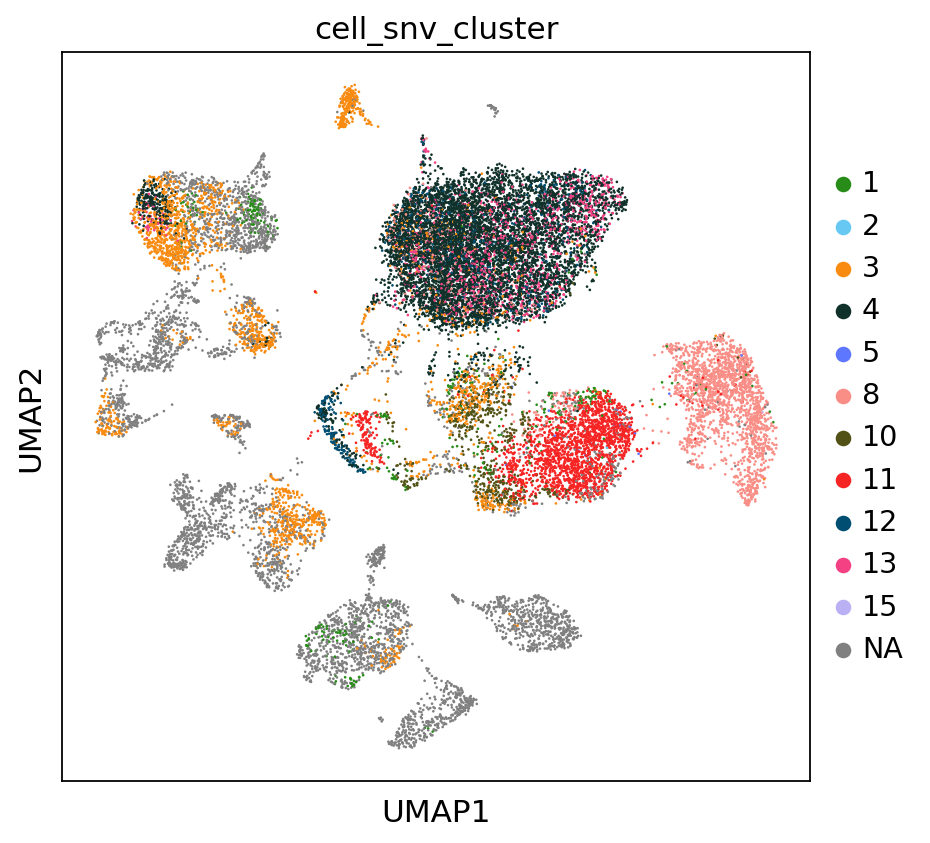

In [57]:
sc.settings.set_figure_params(figsize=(6, 6))
sc.pl.umap(union_no_dupe, color='cell_snv_cluster')
          #save='pat2389_umap_ignat_clonal_assignment_all_cells.png')

In [37]:
union_no_dupe.write('pat2389_with_ignat_cell_assignment_050323.h5ad')

In [4]:
union_no_dupe = sc.read_h5ad('pat2389_with_ignat_cell_assignment_050323.h5ad')

/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


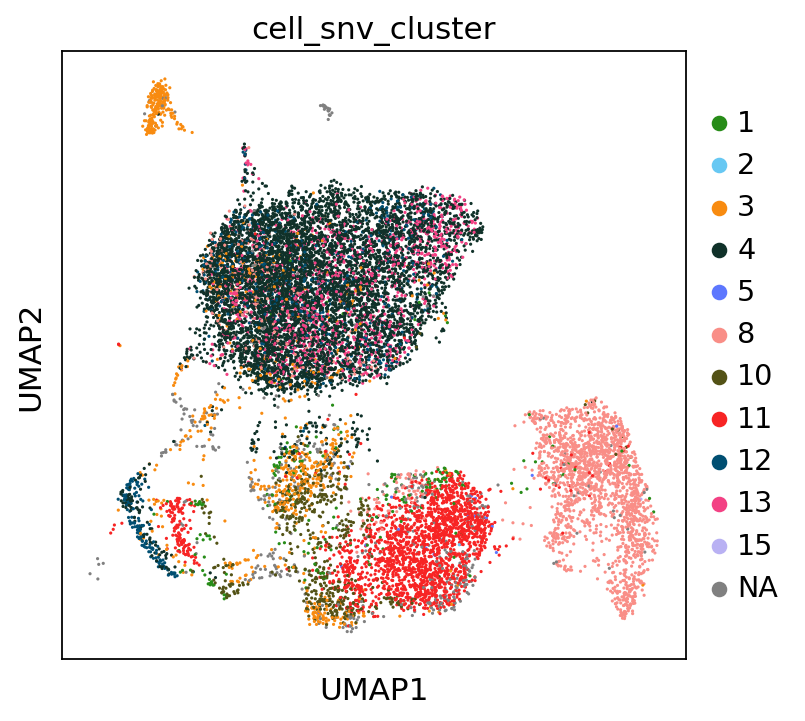

In [9]:
sc.settings.set_figure_params(figsize=(5, 5))
sc.pl.umap(union_no_dupe[union_no_dupe.obs["Cell_type"] == "Epithelial_breast", :], color='cell_snv_cluster',
        save='pat2389_umap_ignat_clonal_assignment_cell_type.png'  )

/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


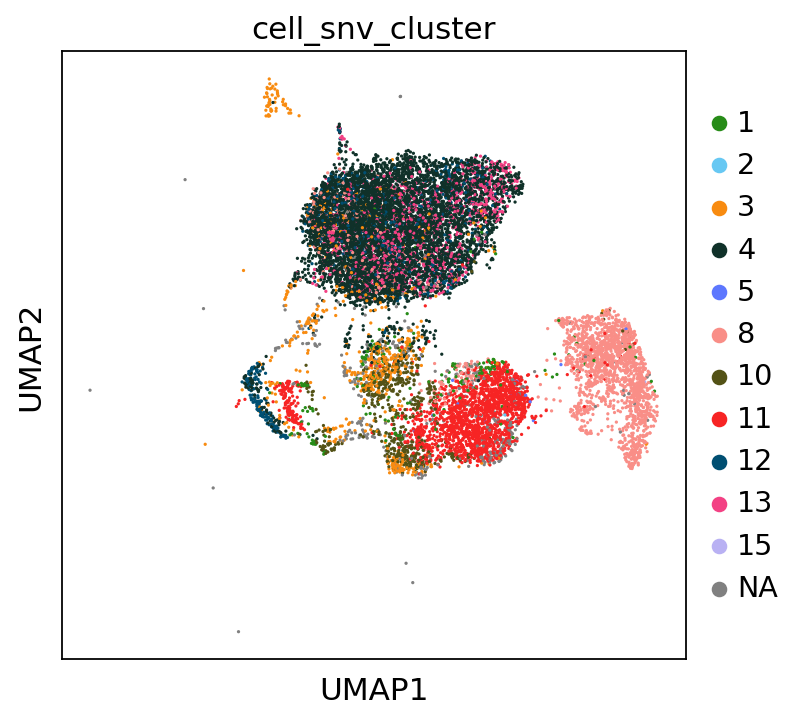

In [45]:
#tumor_cells = union_no_dupe[union_no_dupe.obs["cnv_status"] == "tumor", :]
sc.pl.umap(union_no_dupe[union_no_dupe.obs["Cell_type"] == "tumor", :], color='cell_snv_cluster',
          save='pat2389_umap_ignat_clonal_assignment_tumor.png')

## update colors according to newer tree 11/16/23

In [6]:
clust_list = ['cluster_1', 'cluster_2', 'cluster_3',
                          'cluster_4', 'cluster_5', 'cluster_6',
                          'cluster_7', 'cluster_8', 'cluster_9',
                          'cluster_10', 'cluster_11', 'cluster_12',
                          'cluster_13', 'cluster_14', 'cluster_15','cluster_16','cluster_17','cluster_18',np.nan]

phylo_clust_colors = [phylo_colors[str(i)] for i in range(1,len(clust_list))]
phylo_clust_colors.append('gray')
clusts_colors = dict(zip(clust_list, phylo_clust_colors))
clusts_colors[None] = 'gray'

In [12]:
clusts_colors

{'cluster_1': '#278C18',
 'cluster_2': '#67C8F3',
 'cluster_3': '#F88B10',
 'cluster_4': '#103129',
 'cluster_5': '#5D77FE',
 'cluster_6': '#98161A',
 'cluster_7': '#68ECAC',
 'cluster_8': '#F98E87',
 'cluster_9': '#371230',
 'cluster_10': '#535216',
 'cluster_11': '#F72424',
 'cluster_12': '#004F72',
 'cluster_13': '#F34184',
 'cluster_14': '#3CB9B3',
 'cluster_15': '#B9B1F3',
 'cluster_16': '#8B2243',
 'cluster_17': '#B229BA',
 'cluster_18': '#3A92E7',
 nan: 'gray',
 None: 'gray'}

In [42]:
phylo_colors_for_umap_v2 = [phylo_clust_colors[0],phylo_clust_colors[1],
                            phylo_clust_colors[2],
                            
                            phylo_clust_colors[4],
                               phylo_clust_colors[3],
                            
                            
                            phylo_clust_colors[10],
                            phylo_clust_colors[16],
                            
                               phylo_clust_colors[8],
                            phylo_clust_colors[9],
                            
                         phylo_clust_colors[13],
                            phylo_clust_colors[5],
                         'gray']

In [43]:
phylo_colors_for_umap_v2

['#278C18',
 '#67C8F3',
 '#F88B10',
 '#5D77FE',
 '#103129',
 '#F72424',
 '#B229BA',
 '#371230',
 '#535216',
 '#3CB9B3',
 '#98161A',
 'gray']

In [44]:
#union_no_dupe.obs['cell_snv_cluster'] = union_mapping.to_list()
union_no_dupe.uns['cell_snv_cluster_colors'] = phylo_colors_for_umap_v2

In [45]:
union_no_dupe.uns['cell_snv_cluster_colors_v2']

['#278C18',
 '#67C8F3',
 '#F88B10',
 '#5D77FE',
 '#103129',
 '#F72424',
 '#B229BA',
 '#004F72',
 '#535216',
 '#3CB9B3',
 '#98161A',
 'gray']

/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


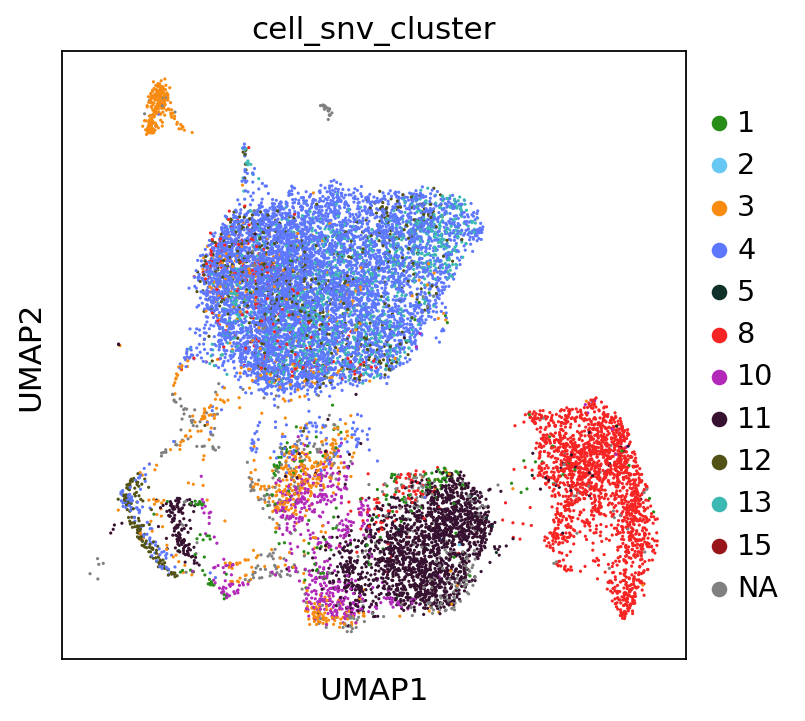

In [46]:
sc.settings.set_figure_params(figsize=(5, 5))
sc.pl.umap(union_no_dupe[union_no_dupe.obs["Cell_type"] == "Epithelial_breast", :], color='cell_snv_cluster')

/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


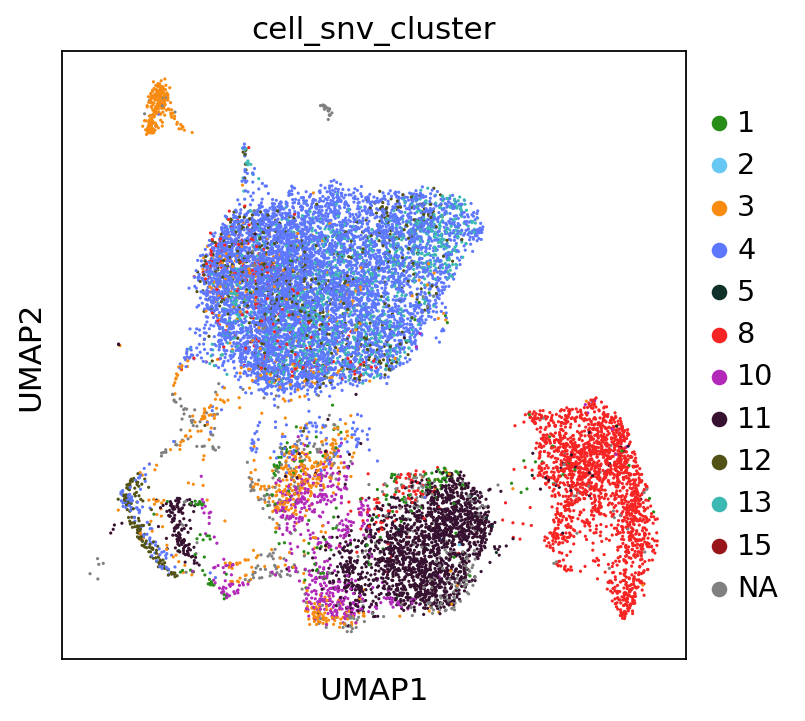

In [48]:
sc.pl.umap(union_no_dupe[union_no_dupe.obs["Cell_type"] == "Epithelial_breast", :], color='cell_snv_cluster',
        save='pat2389_umap_ignat_clonal_assignment_recolored_112823.svg'  )

## CNV plot by clone

In [31]:



def chromosome_heatmap_v2(
    adata: AnnData,
    *,
    groupby: str = "cnv_leiden",
    use_rep: str = "cnv",
    cmap: Union[str, Colormap] = "bwr",
    figsize: Tuple[int, int] = (20, 10),
    show: Optional[bool] = None,
    save: Union[str, bool, None] = None,
    **kwargs,
) -> Optional[Dict[str, matplotlib.axes.Axes]]:
    """
    Plot a heatmap of smoothed gene expression by chromosome.
    Wrapper around :func:`scanpy.pl.heatmap`.
    Parameters
    ----------
    adata
        annotated data matrix
    groupby
        group the cells by a categorical variable from adata.obs. It usually makes
        sense to either group by unsupervised clustering obtained from
        :func:`infercnvpy.tl.leiden` (the default) or a cell-type label.
    use_rep
        Key under which the result from :func:`infercnvpy.tl.infercnv` are stored.
    cmap
        colormap to use
    figsize
        (width, height) tuple in inches
    show
        Whether to show the figure or to return the axes objects.
    save
        If `True` or a `str`, save the figure. A string is appended to the default filename.
        Infer the filetype if ending on `{'.pdf', '.png', '.svg'}`.
    **kwargs
        Arguments passed on to :func:`scanpy.pl.heatmap`.
    Returns
    -------
    If `show` is False, a dictionary of axes.
    """
    if groupby == "cnv_leiden" and "cnv_leiden" not in adata.obs.columns:
        raise ValueError(
            "'cnv_leiden' is not in `adata.obs`. Did you run `tl.leiden()`?"
        )
    tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)
    
     # transfer colors from adata if present
    if f"{groupby}_colors" in adata.uns:
        tmp_adata.uns[f"{groupby}_colors"] = adata.uns[f"{groupby}_colors"]

    # re-sort, as saving & loading anndata destroys the order
    chr_pos_dict = dict(
        sorted(adata.uns[use_rep]["chr_pos"].items(), key=lambda x: x[1])
    )
    chr_pos = list(chr_pos_dict.values())

    # center color map at 0
    tmp_data = tmp_adata.X.data if issparse(tmp_adata.X) else tmp_adata.X
    norm = TwoSlopeNorm(0, vmin=-0.2, vmax=0.2) #np.nanmin(tmp_data) #np.nanmax(tmp_data)

    # add chromosome annotations
    var_group_positions = list(zip(chr_pos, chr_pos[1:] + [tmp_adata.shape[1]]))

    return_ax_dic = sc.pl.heatmap(
        tmp_adata,
        var_names=tmp_adata.var.index.values,
        groupby=groupby,
        figsize=figsize,
        cmap=cmap,
        show_gene_labels=False,
        var_group_positions=var_group_positions,
        var_group_labels=list(chr_pos_dict.keys()),
        norm=norm,
        show=False,
        **kwargs,
    )

    return_ax_dic["heatmap_ax"].vlines(
        chr_pos[1:], lw=0.6, ymin=0, ymax=tmp_adata.shape[0]
    )

    sc.plotting._utils.savefig_or_show("heatmap", show=show, save=save)
    show = sc.settings.autoshow if show is None else show
    if not show:
        return return_ax_dic

/tmp/ipykernel_10405/2803129738.py:44: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 1, 2, 3, etc.
var_group_labels: chr1, chr2, chr3, etc.


/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


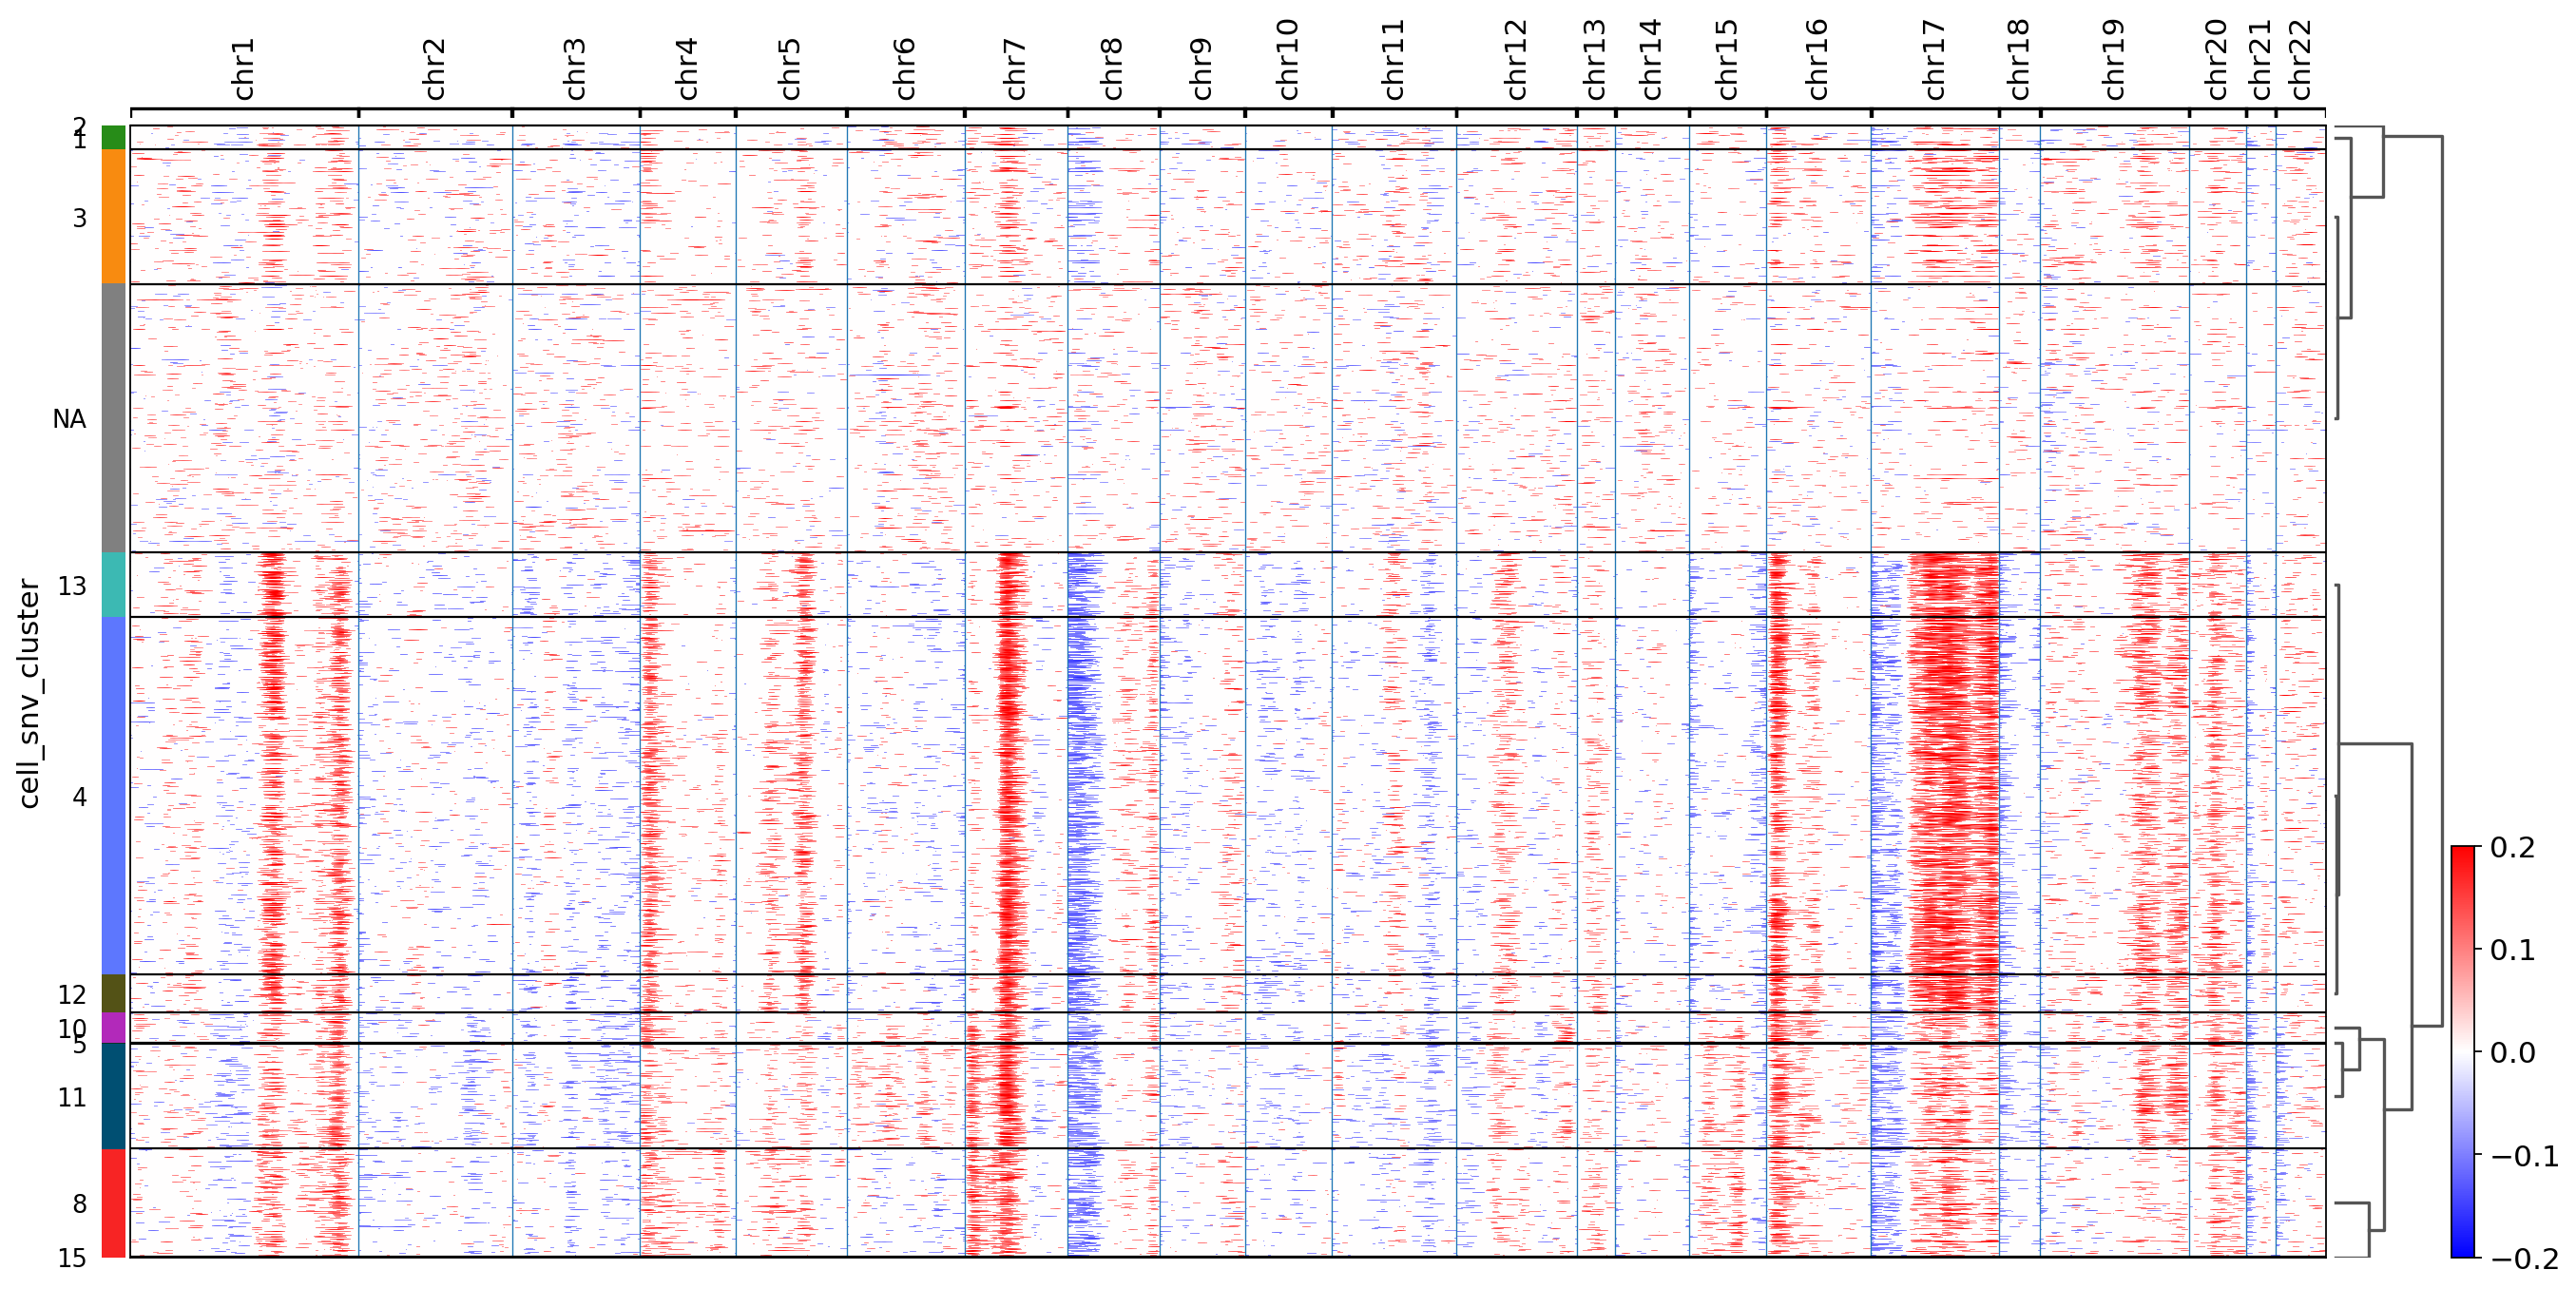

In [32]:
chromosome_heatmap_v2(union_no_dupe,groupby='cell_snv_cluster', dendrogram=True,
                     save='pat2389_ignat_clonal_assignment_all_cells_recolored_111623.png')

/tmp/ipykernel_10405/2803129738.py:44: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)


         Falling back to preprocessing with `sc.pp.pca` and default params.
categories: 1, 2, 3, etc.
var_group_labels: chr1, chr2, chr3, etc.


/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


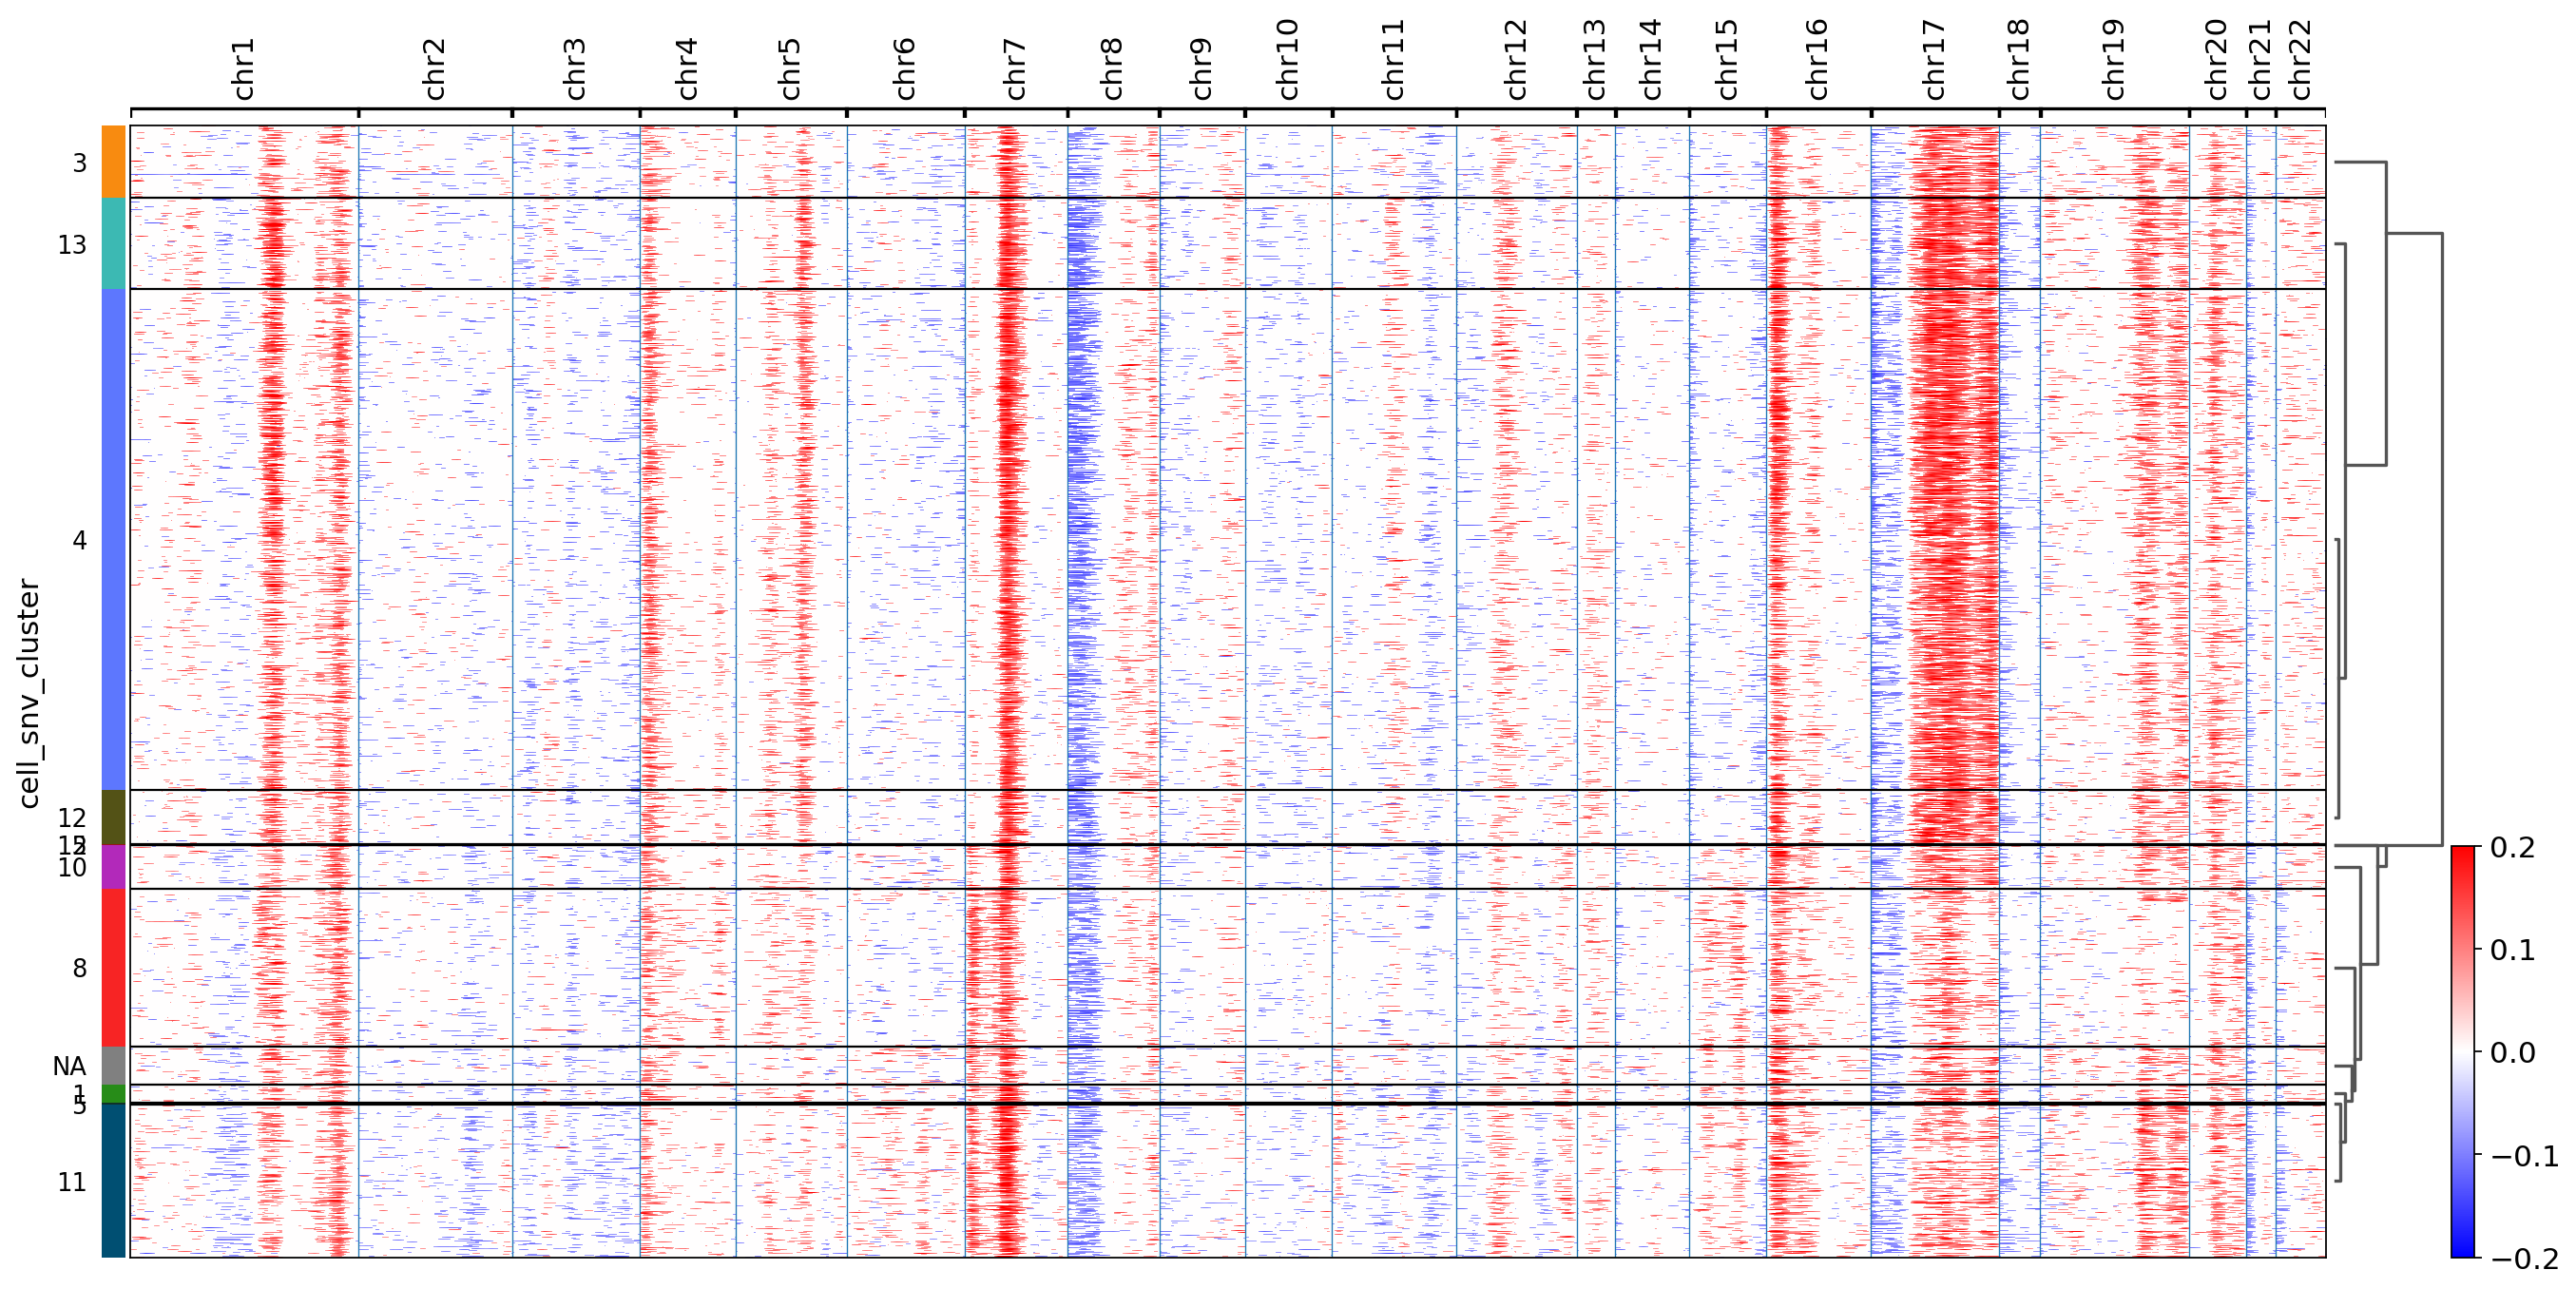

In [33]:
chromosome_heatmap_v2(union_no_dupe[union_no_dupe.obs["Cell_type"] == "Epithelial_breast", :],groupby='cell_snv_cluster', dendrogram=True,
                     save='pat2389_ignat_clonal_assignment_breast_cells_recolored_111623.png')

/tmp/ipykernel_10405/2803129738.py:44: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)


/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


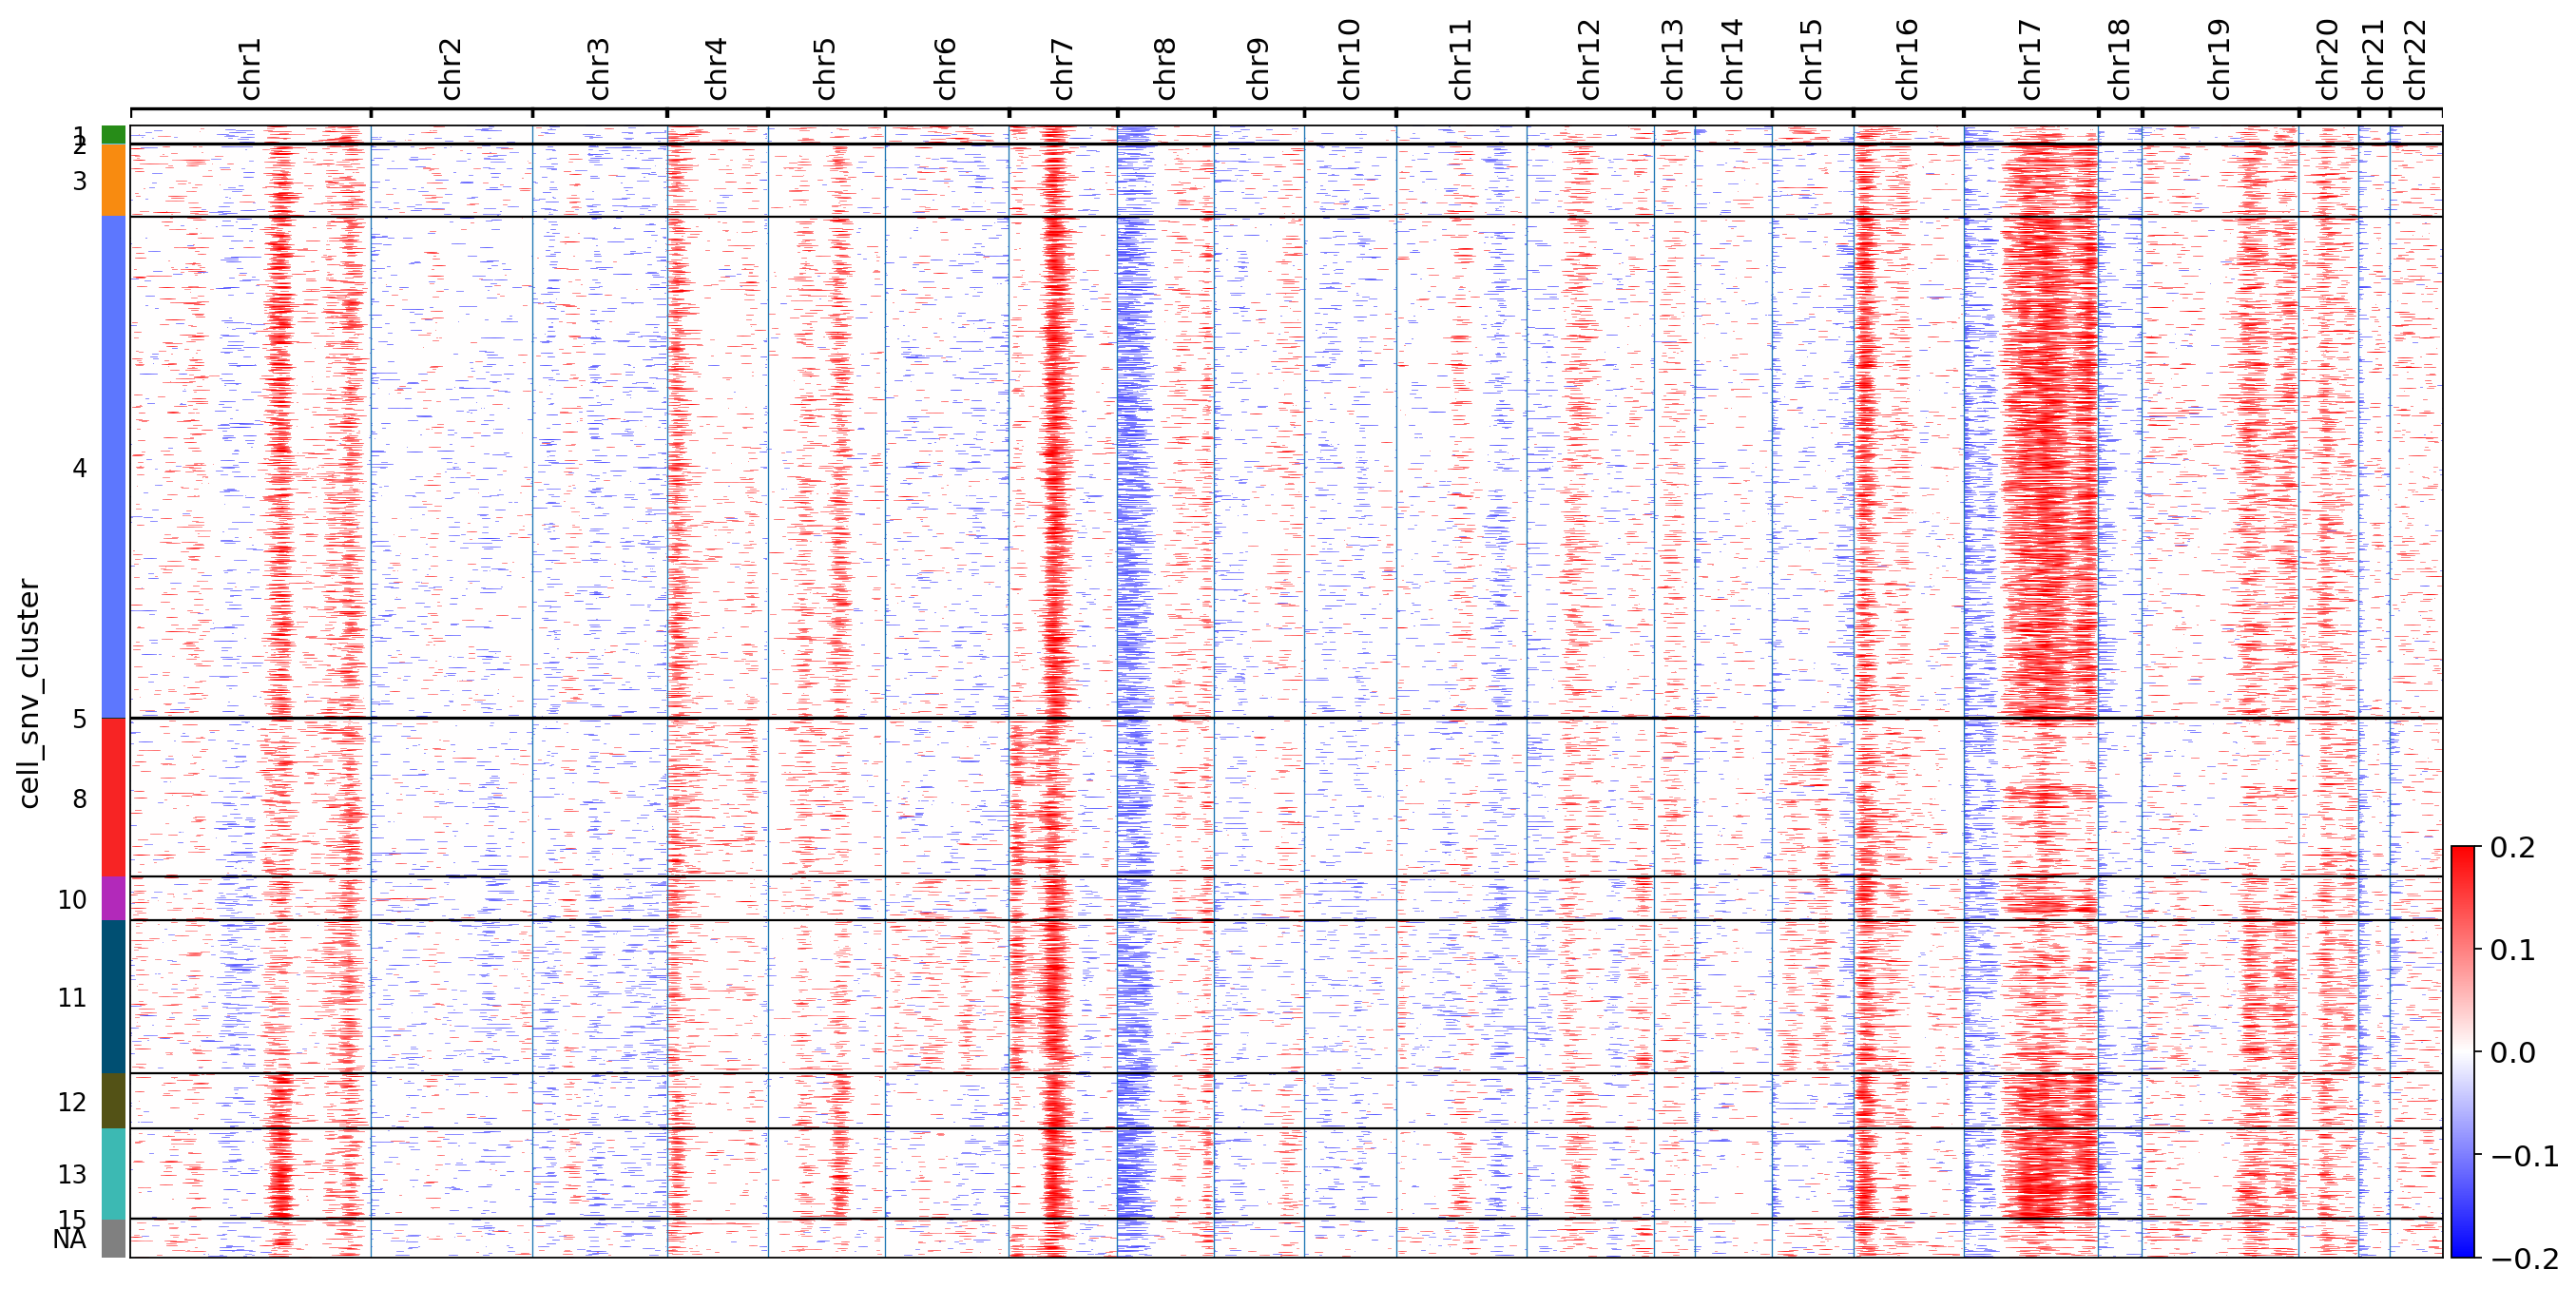

In [35]:
chromosome_heatmap_v2(union_no_dupe[union_no_dupe.obs["Cell_type"] == "Epithelial_breast", :],groupby='cell_snv_cluster', dendrogram=False,
                     save='pat2389_ignat_clonal_assignment_breast_cells_no_dendrogram_recolored_111623.svg')

/tmp/ipykernel_9154/2803129738.py:44: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  tmp_adata = AnnData(X=adata.obsm[f"X_{use_rep}"], obs=adata.obs)
/opt/conda/envs/py38/lib/python3.8/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


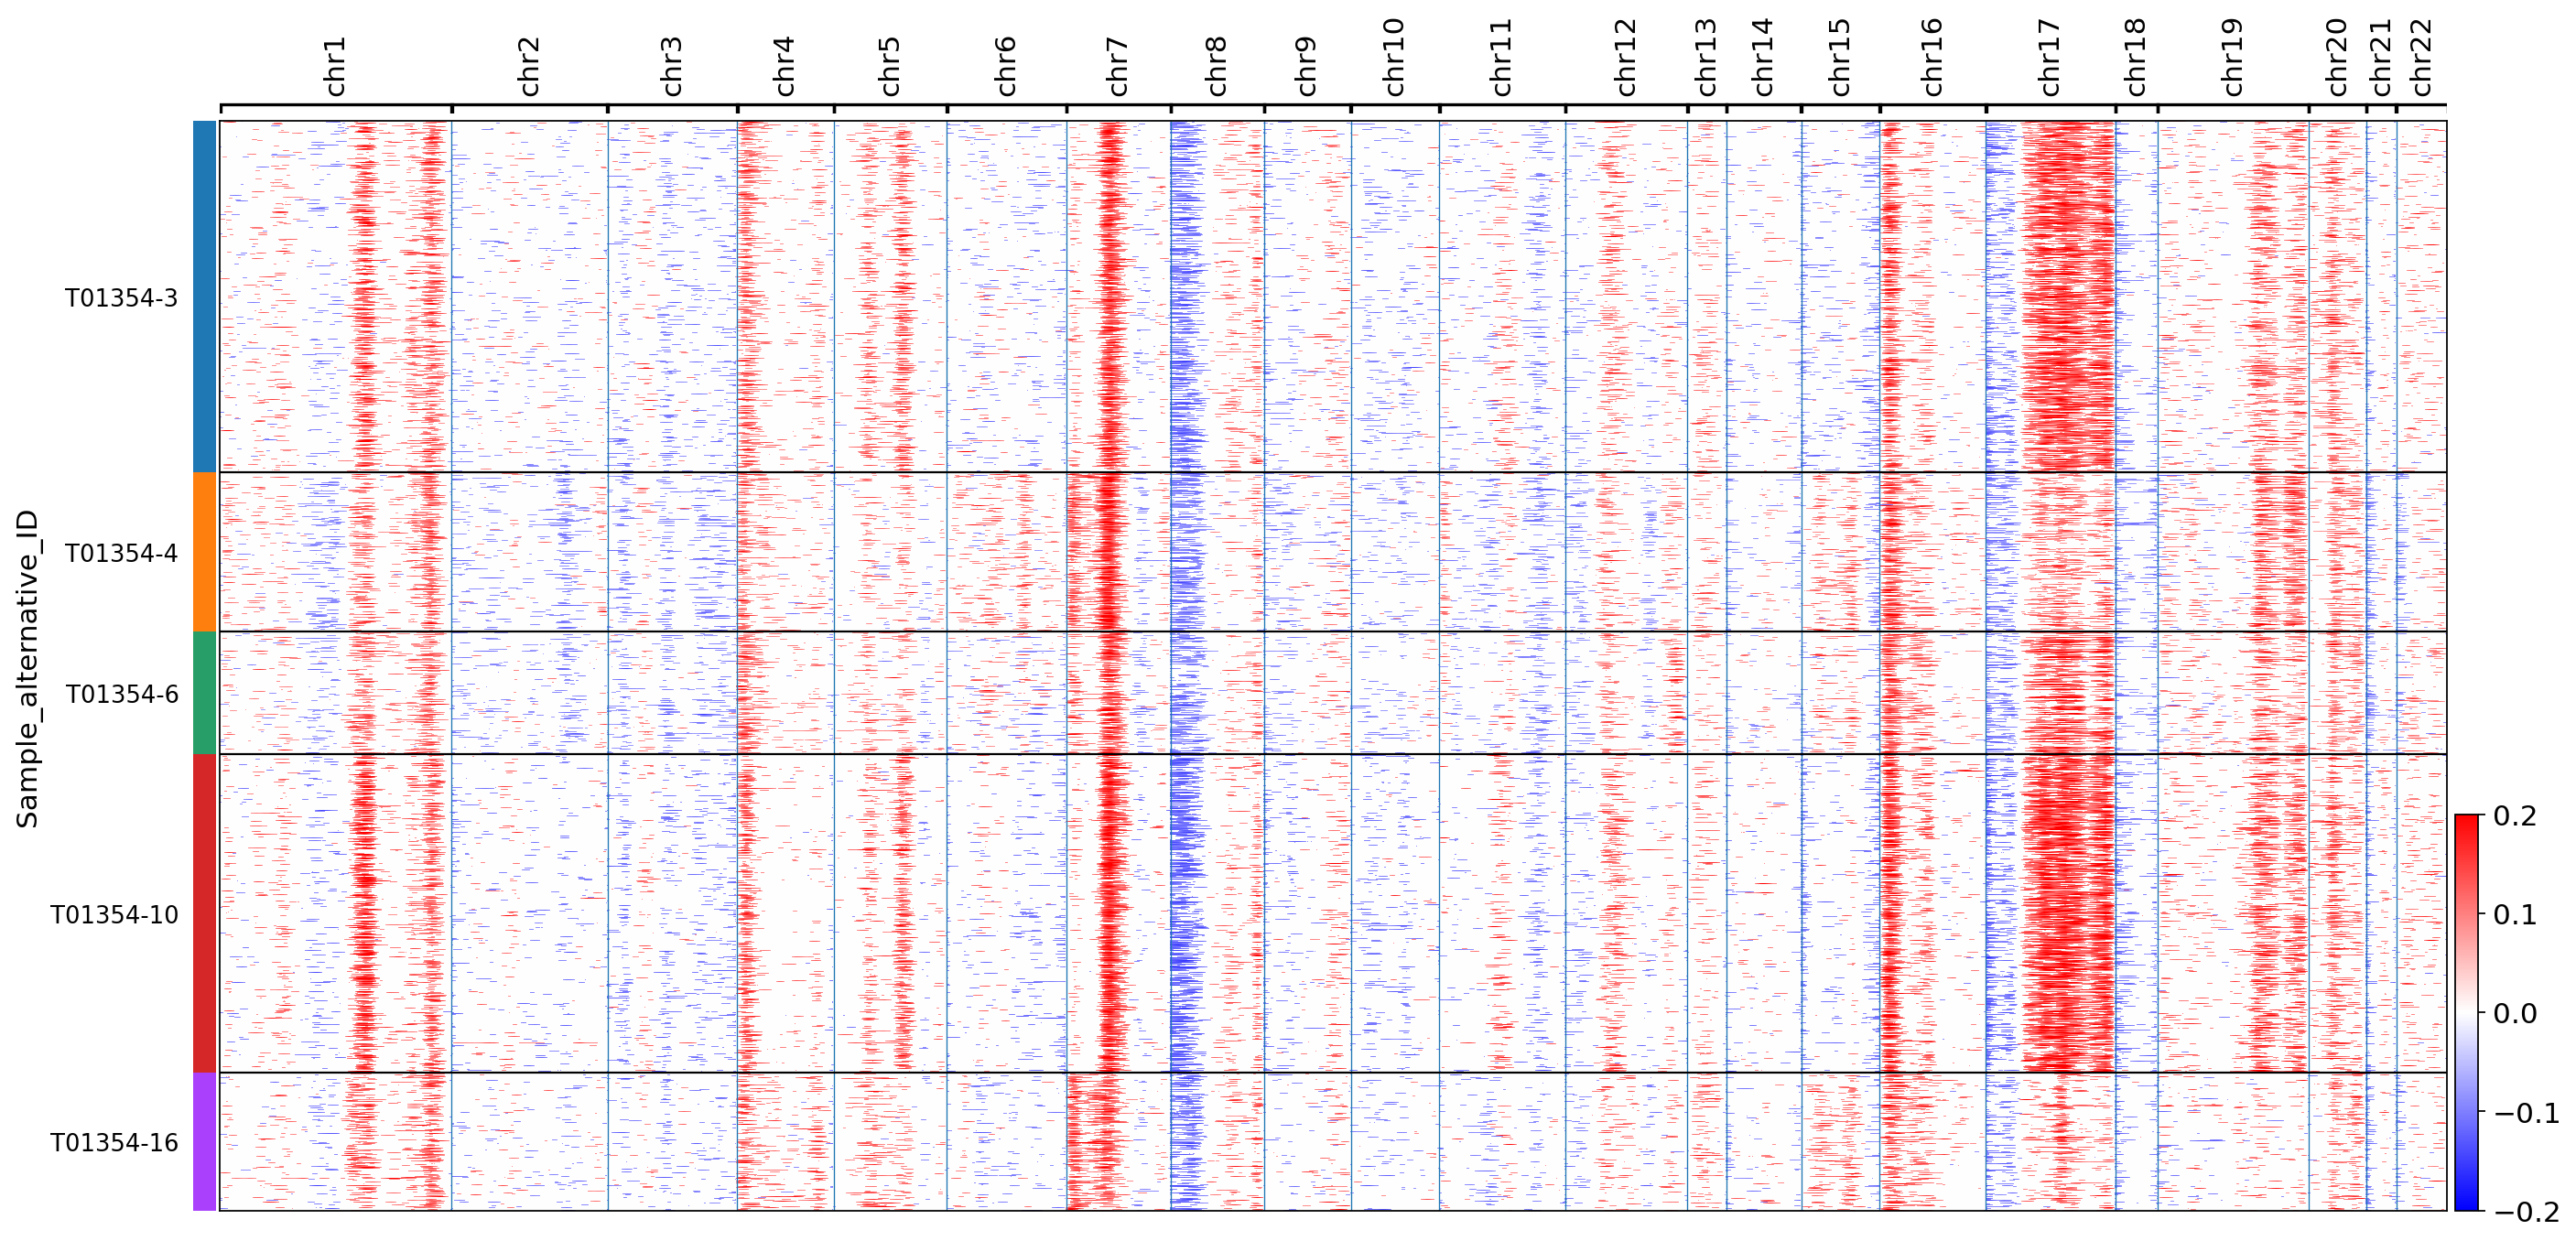

In [7]:
chromosome_heatmap_v2(union_no_dupe[union_no_dupe.obs["Cell_type"] == "Epithelial_breast", :],groupby='Sample_alternative_ID', dendrogram=False)



In [11]:
breast_cells = union_no_dupe[union_no_dupe.obs["Cell_type"] == "Epithelial_breast", :]
breast_cells_matrix = breast_cells.obsm['X_cnv'].todense()
single_cell_calls_df = pd.DataFrame(breast_cells_matrix)
